# PASA Proyecto 1

Eliminación de ruido de EOG y EMG

# Preparación del Entorno

- Instalación de librerías
- Descarga de Dataset

In [1]:
# Para instalar en el entorno la librería para RW de archivos .edf
!pip install pyedflib
!pip install padasip

In [2]:
# Usar este comando cambiando el final del link para descargar archivos individuales
# El database completo pesa 40.1 GB y va a estar todo el día
!wget -r -N -c -np https://physionet.org/files/hmc-sleep-staging/1.1/recordings/SN001.edf

--2022-11-22 17:09:36--  https://physionet.org/files/hmc-sleep-staging/1.1/recordings/SN001.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



# Carga de Datos

- Extracción de información del dataset
- Extracción de canales a analizar

*Probablemente haya que usar otra base de datos porque esta tiene pasabajos en 30Hz, y no se va a ver nada importante me parece*

In [484]:
from pyedflib import highlevel
signals, signal_headers, header = highlevel.read_edf('SN001.edf')

## Información sobre el Dataset

In [485]:
print('Lista de Canales en esta base de datos: \n')
for sh in signal_headers:
  print(sh['label'], '  \t' ,sh['prefilter'],'  \tSample Rate:',sh['sample_rate'])

Lista de Canales en esta base de datos: 

EEG F4-M1   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EEG C4-M1   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EEG O2-M1   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EEG C3-M2   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EMG chin   	 HP:1.0Hz LP:150.0Hz   	Sample Rate: 256.0
EOG E1-M2   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
EOG E2-M2   	 HP:0.2Hz LP:35.0Hz   	Sample Rate: 256.0
ECG   	 HP:1.0Hz LP:150.0Hz   	Sample Rate: 256.0


La CAP Sleep Database es una colección de 108 grabaciones de Polysomniogramas del Sleep Disorders Center de Ospedale Maggiore de Parma, Italia.

Se usarán los siguientes canales para la eliminación de ruido de EEG por EOG o EMG:

- **ROC - LOC** corresponde al canal EOG de medición diferencial entre los transductores oculares derechos e izquierdos.
- **EMG1-EMG2** corresponde al canal EMG de medición diferencial entre los transductores en el músculo submental (debajo del mentón).
- **X# - Y#** corresponden a canales de EEG X# en referencia a Y#

Se debe notar que el ruido de línea ya está filtrado en esta base de datos

## Carga del Dataset

### Funciones Auxiliares

In [486]:
import padasip as pa
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [487]:
def signal_grab(signals, headers, i):
  '''
  Extract data to be used from the dataset
  '''
  retval = {
      'name': headers[i]['label'],
      'fs': headers[i]['sample_rate'],
      'data': signals[i],
      'units': headers[i]['dimension']
  }
  return retval

def signal_grab_dt(signals, headers, i, dt):
  '''
  Extract data to be used from the dataset
  dt: Time period (s)
  '''
  fs = headers[i]['sample_rate']
  dt = np.array(dt)
  dt = dt * int(fs)
  retval = {
      'name': headers[i]['label'],
      'fs': fs,
      'data': signals[i][dt[0]:dt[1]],
      'units': headers[i]['dimension']
  }
  return retval

In [488]:
def signal_plot(series, fig_size=(10,15)):
  figure, axes = plt.subplots(nrows= len(series), figsize=fig_size)
  for i,s in enumerate(series):
    axes[i].plot(s['data'])
    axes[i].set_title(s['name'])
    axes[i].set_ylabel(s['units'])
    axes[i].set_xlim((0,s['data'].size))
  
  axes[-1].set_xlabel('sample')
  plt.tight_layout()
  plt.show()

def signal_plot_N(series, N, fig_size=(10,15)):
  figure, axes = plt.subplots(nrows= len(series), figsize=fig_size)
  for i,s in enumerate(series):
    axes[i].plot(s['data'][:N])
    axes[i].set_title(s['name'])
    axes[i].set_ylabel(s['units'])
    axes[i].set_xlim((0,s['data'].size))

  axes[:-2].set_xticks([])
  axes[-1].set_xlabel('sample')
  plt.show()

In [489]:
def spectrum_plot(series, fig_size=(10,15)):
  figure, axes = plt.subplots(nrows= len(series), figsize=fig_size)
  for i,s in enumerate(series):
    f, psd = signal.welch(s['data'], fs=s['fs'], window='bartlett')
    axes[i].semilogx(f, 10*np.log10(psd))
    axes[i].set_title(s['name'])
    axes[i].set_xlabel('f [Hz]')
    axes[i].set_ylabel('PSD [V**2/Hz]')
    axes[i].set_xlim((1,1000))
    axes[i].set_ylim((1e-3,1e4))
  plt.show()

def spectrum_plot_n0(series, N0, fig_size=(10,15)):
  figure, axes = plt.subplots(nrows= len(series), figsize=fig_size)
  for i,s in enumerate(series):
    f, psd = signal.welch(s['data'], fs=s['fs'], window='bartlett', nfft = N0)
    axes[i].semilogx(f, 10*np.log10(psd))
    axes[i].set_title(s['name'])
    axes[i].set_xlabel('f [Hz]')
    axes[i].set_ylabel('PSD [V**2/Hz]')
    axes[i].set_xlim((1,1000))
    axes[i].set_ylim((1e-3,1e2))
  plt.show()

def spectrum_plot_1(series, N0, title='Espectro de Potencia', fig_size=(10,15)):
  figure = plt.figure(1, fig_size)
  for i,s in enumerate(series):
    f, psd = signal.welch(s['data'], fs=s['fs'], window='bartlett', nfft = N0)
    plt.plot(f, 10*np.log10(psd))
  
  plt.legend([x['name'] for x in series])
  plt.ylabel('PSD [dB]')
  plt.xlabel('f [Hz]')
  plt.title(title)
  plt.xlim((0,128))
  plt.grid()
  plt.show()

## Visualización de señales

In [490]:
EEG_norm = signal_grab(signals, signal_headers, 3)
EOG_norm = signal_grab(signals, signal_headers, 5)
EMG_norm = signal_grab(signals, signal_headers, 4)

EEG = signal_grab(signals, signal_headers, 3)
EOG = signal_grab(signals, signal_headers, 5)
EMG = signal_grab(signals, signal_headers, 4)

In [491]:
EEG['data'].size

6566400

In [492]:
dt = (0,10)
EEG = signal_grab_dt(signals, signal_headers, 3, dt)
EOG = signal_grab_dt(signals, signal_headers, 5, dt)
EMG = signal_grab_dt(signals, signal_headers, 4, dt)

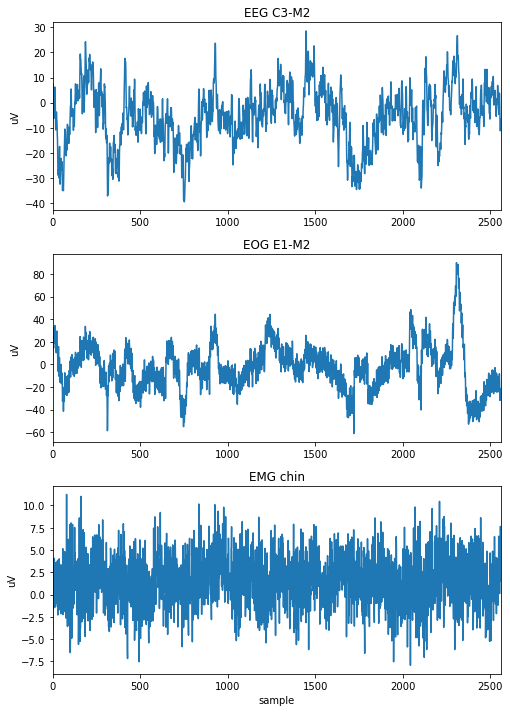

In [493]:
signal_plot([EEG, EOG, EMG], fig_size=(7.16,10))

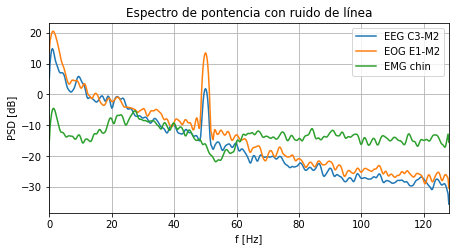

In [494]:
N0 = 1024
#spectrum_plot_n0([EEG, EOG, EMG], N0, fig_size=(20,15))
spectrum_plot_1([EEG, EOG, EMG], N0, title='Espectro de pontencia con ruido de línea', fig_size=(7.16,3.5))

In [495]:
def get_power_at_f(series, f, N0):
  freqs, psd = signal.welch(series['data'], fs=series['fs'], nfft=N0)
  i = np.where(freqs == f)
  return psd[i]

In [496]:
f, psd = signal.welch(EEG['data'], fs=EEG['fs'], nfft=N0)
i = np.where(f == 50)
print('Power at 50 Hz =', psd[i])

i = np.where(f==1.25)
print('Power at 1.25 Hz=', psd[i])

Power at 50 Hz = [1.38003427]
Power at 1.25 Hz= [25.45803448]


In [497]:
print('Power at 50 Hz =', get_power_at_f(EEG, 50, N0))

print('Power at 1.25 Hz =', get_power_at_f(EEG, 1.25, N0))

Power at 50 Hz = [1.38003427]
Power at 1.25 Hz = [25.45803448]


Se observa ruido de línea presente en 50 Hz

In [498]:
f, psd = signal.welch(EOG['data'], fs=EOG['fs'], nfft=N0)
i = np.where(psd == psd.max())

print('Frequency at max power =', f[i])

Frequency at max power = [1.25]


In [499]:
f, psd = signal.welch(EMG['data'], fs=EMG['fs'], nfft=N0)
i = np.where(psd == psd.max())

print('Frequency at max power =', f[i])

Frequency at max power = [1.25]


# Procesamiento de Datos

In [500]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import progressbar as pb

## Funciones Auxiliares

In [501]:
def data_tap(x, M):
  '''
  Genera la matriz de taps MxN
  '''
  N = x.size
  x = np.array(x).reshape(N)
  x_M = np.zeros((N,M))
  
  # Zero-padding
  for m in range(M):
    x_M[m:,m] = x[:N-m]

  return x_M

In [502]:
def filter_notch(seriess, f, Q):
  for s in seriess:
    # Design notch filter
    b, a = signal.iirnotch(f, Q, s['fs'])

    # Filter signals
    s['data'] = signal.filtfilt(b, a, s['data'])

  return seriess

## Análisis

### Normalizacion

In [22]:
#Normalizacion
EOG_mean = EOG['data'].mean()
EOG_std = EOG['data'].std()
EOG_norm['data'] = (EOG['data'] - EOG_mean) / EOG_std


EEG_mean = EEG['data'].mean()
EEG_std = EEG['data'].std()
EEG_norm['data'] = (EEG['data'] - EEG_mean) / EEG_std


EMG_mean = EMG['data'].mean()
EMG_std = EMG['data'].std()
EMG_norm['data'] = (EMG['data'] - EMG_mean) / EMG_std


### Eliminación de Ruido de Línea en las 3 series

In [503]:
f_notch = 50  # Hz
Q = 40

[EEG, EOG, EMG] = filter_notch([EEG, EOG, EMG], f_notch, Q)

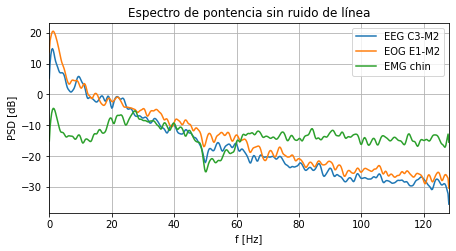

In [504]:
spectrum_plot_1([EEG, EOG, EMG], N0, title='Espectro de pontencia sin ruido de línea', fig_size=(7.16,3.5))

In [505]:
print('Power at 50 Hz =', get_power_at_f(EEG, 50, N0))

print('Power at 1.25 Hz =', get_power_at_f(EEG, 1.25, N0))

Power at 50 Hz = [0.0080107]
Power at 1.25 Hz = [25.45837887]


**Análisis LMS**

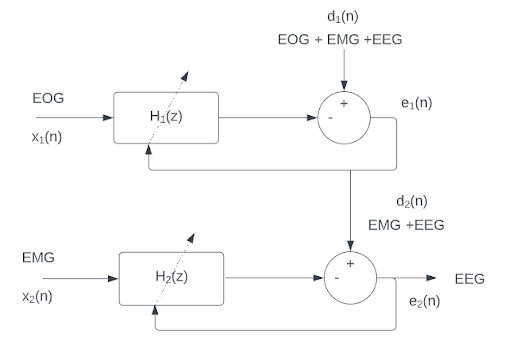

In [506]:
# Primer filtro: x1 = eog, d1 = eeg
M1 = 256
#M1 = 20
eog_M = data_tap(EOG['data'], M1)   # Reference Data (x)

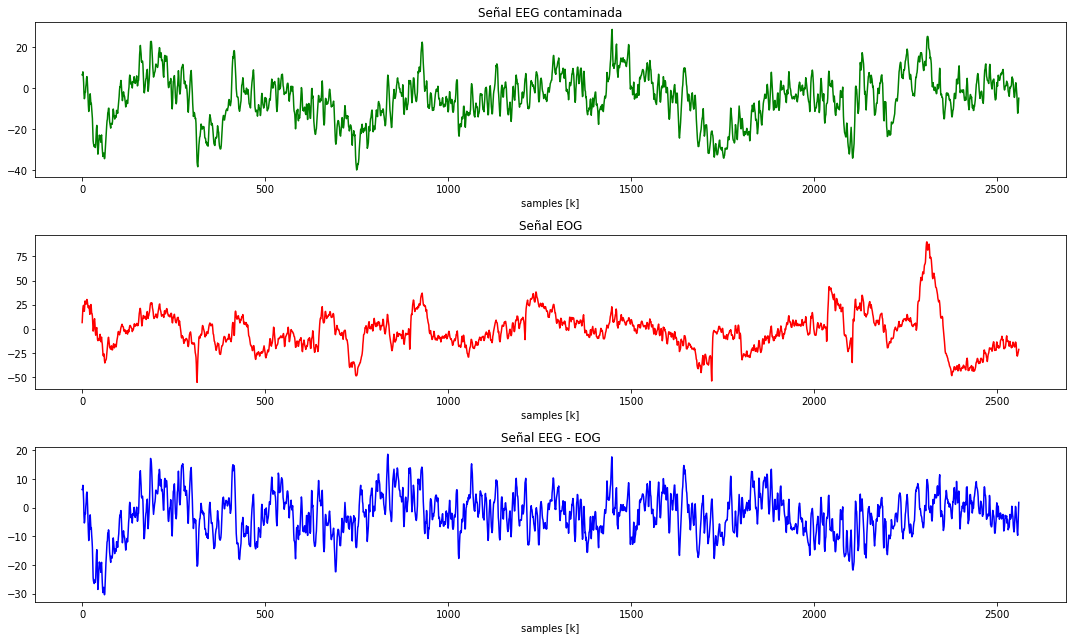

In [507]:
mu1 = 0.000001

f1 = pa.filters.FilterLMS(n = M1, mu=mu1, w='zeros')
y1_LMS, e1_LMS, w1_LMS = f1.run(EEG['data'],eog_M)
#f1 = pa.filters.FilterRLS(n = 20, mu=0.9)
#y1_LMS, e1_LMS, w1_LMS = f1.run(EEG['data'],eog_M)

res1_LMS = {
    'name': 'EEG - EOG',
    'fs': EEG['fs'],
    'data': e1_LMS,
    'units': EEG['units']
}

plt.figure(figsize=(15,9))
plt.subplot(311)
plt.title("Señal EEG contaminada");plt.xlabel("samples [k]")
plt.plot(EEG['data'],"g", label="eeg")

plt.subplot(312)
plt.title("Señal EOG");plt.xlabel("samples [k]")
plt.plot(EOG['data'],"r", label="eog")

plt.subplot(313)
plt.title("Señal EEG - EOG");plt.xlabel("samples [k]")
plt.plot(e1_LMS,"b", label="error")

plt.tight_layout()
plt.show()

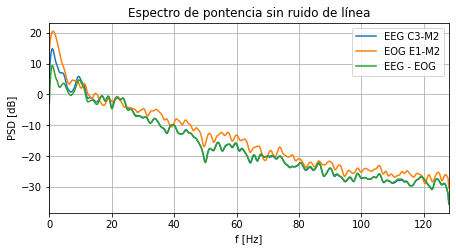

In [508]:
spectrum_plot_1([EEG,EOG, res1_LMS], N0, title='Espectro de pontencia sin ruido de línea', fig_size=(7.16,3.5))

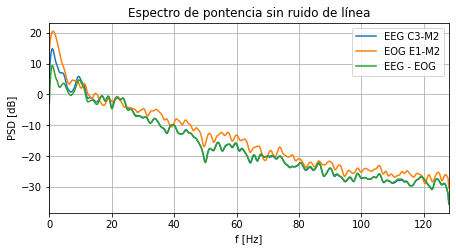

In [509]:
spectrum_plot_1([EEG,EOG, res1_LMS], N0, title='Espectro de pontencia sin ruido de línea', fig_size=(7.16,3.5))

In [510]:
print('Power at 50 Hz =', get_power_at_f(res1_LMS, 50, N0))
print('Power at 1.25 Hz =', get_power_at_f(res1_LMS, 1.25, N0))

Power at 50 Hz = [0.00801704]
Power at 1.25 Hz = [7.41797233]


In [511]:
# Segundo filtro: x2 = emg, d2 = e1 = eeg - eog
M2 = 200
emg_M = data_tap(EMG['data'], M2)

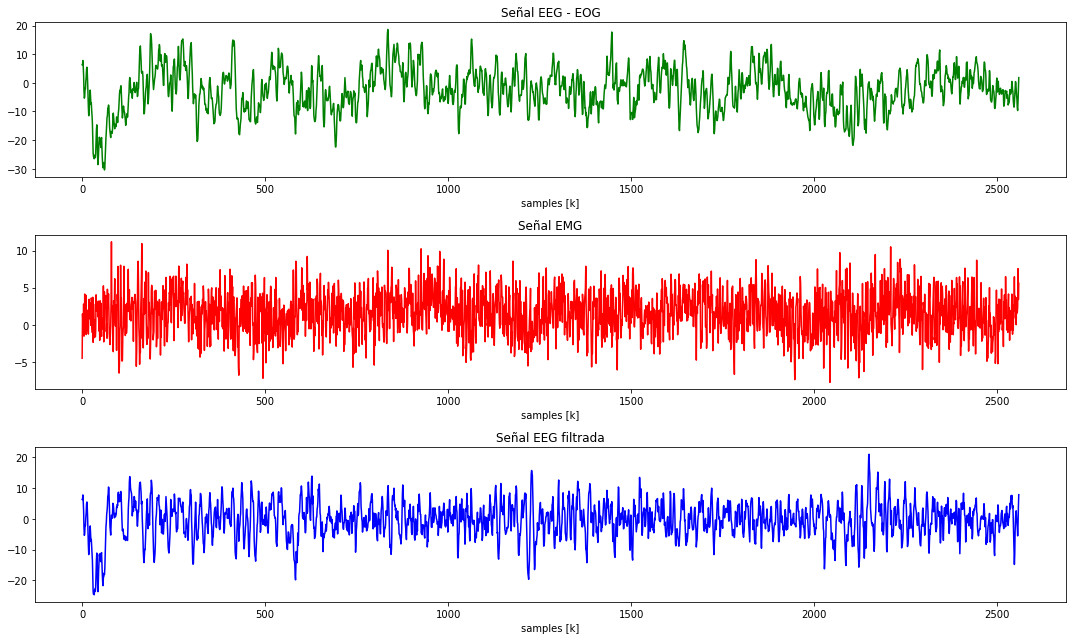

In [516]:
mu2 = 0.0005

f2 = pa.filters.FilterLMS(n = M2, mu=mu2, w='zeros')
y2_LMS, e2_LMS, w2_LMS = f2.run(e1_LMS,emg_M)

res2_LMS = {
    'name': 'EEG - EOG - EMG',
    'fs': EEG['fs'],
    'data': e2_LMS,
    'units': EEG['units']
}

plt.figure(figsize=(15,9))
plt.subplot(311)
plt.title("Señal EEG - EOG");plt.xlabel("samples [k]")
plt.plot(e1_LMS,"g", label="eeg")

plt.subplot(312)
plt.title("Señal EMG");plt.xlabel("samples [k]")
plt.plot(EMG['data'],"r", label="eog")

plt.subplot(313)
plt.title("Señal EEG filtrada");plt.xlabel("samples [k]")
plt.plot(e2_LMS,"b", label="error")

plt.tight_layout()
plt.show()

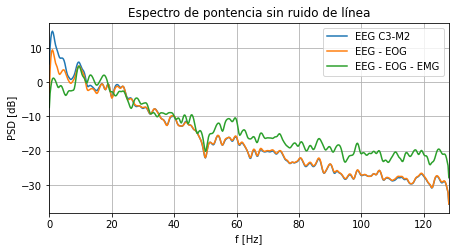

In [517]:
spectrum_plot_1([EEG, res1_LMS, res2_LMS], N0, title='Espectro de pontencia sin ruido de línea', fig_size=(7.16,3.5))

In [518]:
print('Power at 50 Hz =', get_power_at_f(res1_LMS, 50, N0))
print('Power at 1.25 Hz =', get_power_at_f(res1_LMS, 1.25, N0))
print('Power at 1.25 Hz =', get_power_at_f(res2_LMS, 1.25, N0))

Power at 50 Hz = [0.00801704]
Power at 1.25 Hz = [7.41797233]
Power at 1.25 Hz = [1.1570377]


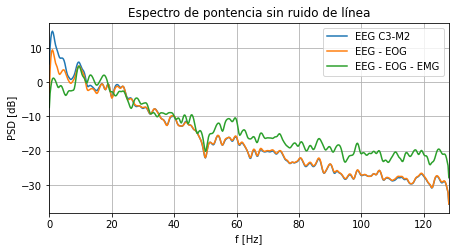

In [519]:
spectrum_plot_1([EEG, res1_LMS, res2_LMS], N0, title='Espectro de pontencia sin ruido de línea', fig_size=(7.16,3.5))

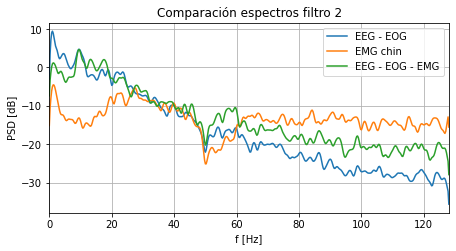

In [521]:
spectrum_plot_1([res1_LMS, EMG, res2_LMS], N0, title='Comparación espectros filtro 2', fig_size=(7.16,3.5))

In [470]:
def plot_w(w, M):
  figure, axes = plt.subplots(nrows=M, figsize=(15,10))
  for i in range(M):
    axes[i].plot(w[:,i])
  plt.show()

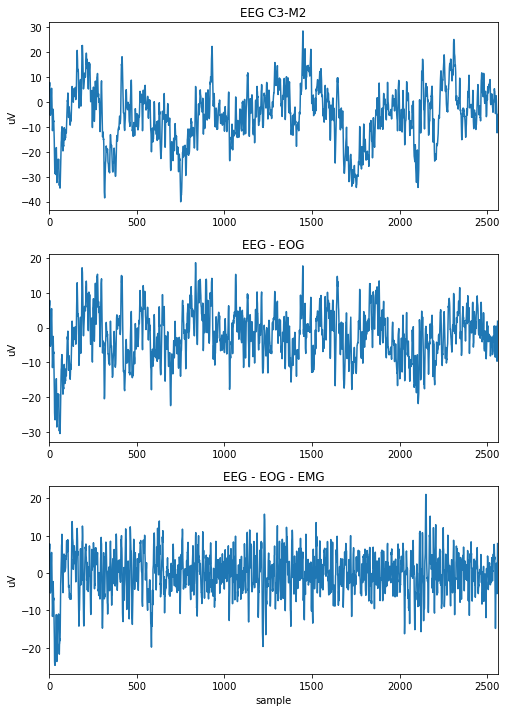

In [522]:
signal_plot([EEG, res1_LMS, res2_LMS], fig_size=(7.16,10))

## Analisis RLS


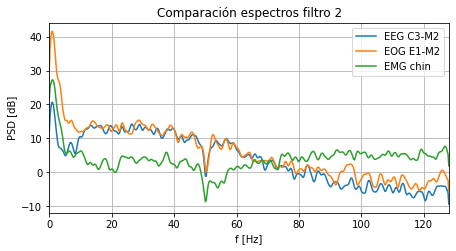

In [472]:
spectrum_plot_1([EEG, EOG, EMG], N0, title='Comparación espectros filtro 2', fig_size=(7.16,3.5))

In [473]:
# Primer filtro: x1 = eog, d1 = eeg
M1 = 400
eog_M = data_tap(EOG['data'], M1)   # Reference Data (x)
#eog_M.shape
#EOG['data'].shape[0]

371.72134517301635
11754.861056483689
2560


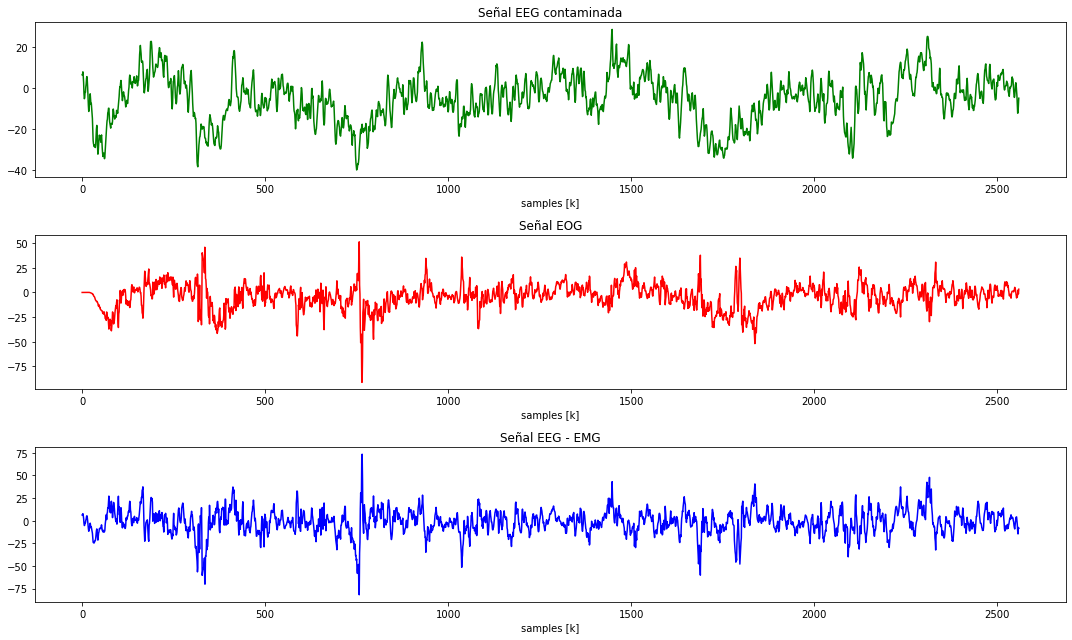

In [560]:
forget_factor = 0.9
order_M= 20
#Como nuestro SNR es menor a 10dB al estar tanto
alpha=-1.5
delta=np.var(EOG['data'])*(1-forget_factor)**alpha

print(np.var(EOG['data']))
print(delta)

#f1 = pa.filters.FilterRLS(n = M1, mu=forget_factor, w='zeros',eps=delta)
#y1_RLS, e1_RLS, w1_RLS = f1.run(EEG['data'],eog_M)

y1_RLS, e1_RLS, w1_RLS =  apply_rls(EMG['data'], EEG['data'], order_M, forget_factor, delta)

#f1 = pa.filters.FilterRLS(n = 400, mu=0.95)
#y1_LMS, e1_LMS, w1_LMS = f1.run(EEG['data'],eog_M)

res1_RLS = {
    'name': 'EEG - EOG',
    'fs': EEG['fs'],
    'data': e1_RLS,
    'units': EEG['units']
}

plt.figure(figsize=(15,9))
plt.subplot(311)
plt.title("Señal EEG contaminada");plt.xlabel("samples [k]")
plt.plot(EEG['data'],"g", label="eeg")

plt.subplot(312)
plt.title("Señal EOG");plt.xlabel("samples [k]")
plt.plot(y1_RLS,"r", label="eog")

plt.subplot(313)
plt.title("Señal EEG - EMG");plt.xlabel("samples [k]")
plt.plot(e1_RLS,"b", label="error")

plt.tight_layout()
plt.show()

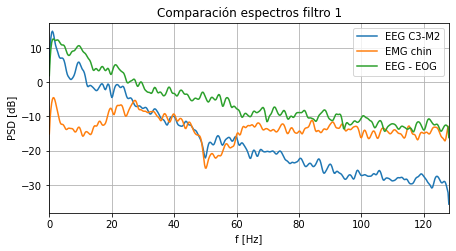

In [561]:
spectrum_plot_1([EEG, EMG, res1_RLS], N0, title='Comparación espectros filtro 1', fig_size=(7.16,3.5))

In [528]:
print('Power at 1.25 Hz =', get_power_at_f(EEG, 1.25, N0))
print('Power at 1.25 Hz =', get_power_at_f(res1_RLS, 1.25, N0))

Power at 1.25 Hz = [25.45837887]
Power at 1.25 Hz = [17.61714625]


In [529]:
# Segundo filtro: x2 = emg, d2 = e1 = eeg - eog
M2 = 400
emg_M = data_tap(EMG['data'], M2)

7.983291292677703
11754.861056483689
2560


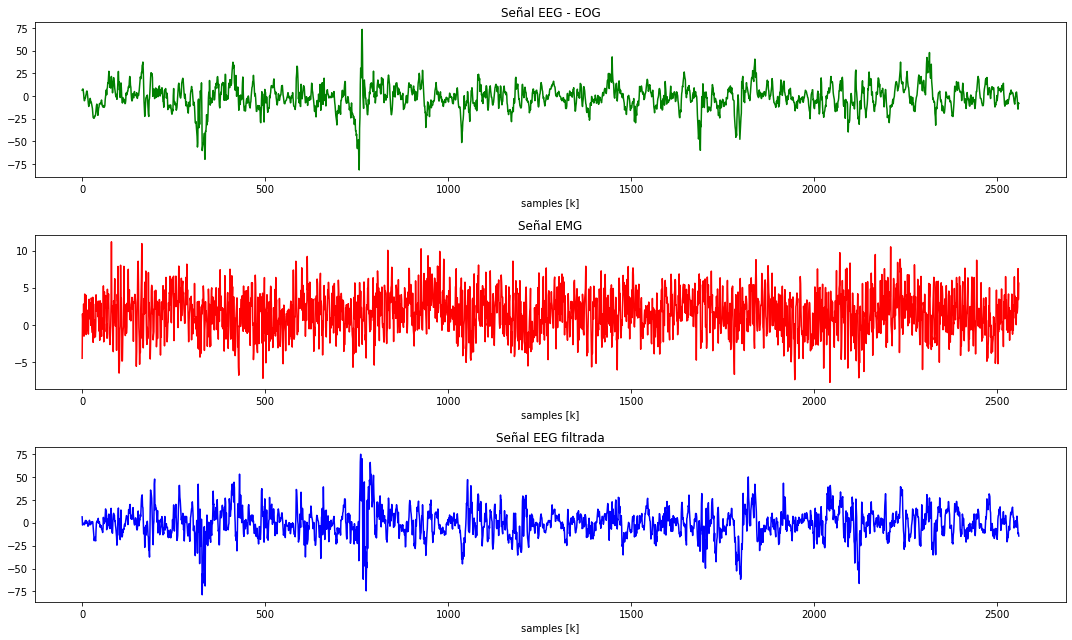

In [562]:
#mu2 = 0.0005
#f2 = pa.filters.FilterLMS(n = M2, mu=mu2, w='zeros')
#y2, e2, w2 = f2.run(e1,emg_M)

forget_factor_2 = 0.9
order_M_2= 20
#Como nuestro SNR es menor a 10dB al estar tanto
alpha_2=-0.5
delta_2=np.var(EMG['data'])*(1-forget_factor_2)**alpha_2

print(np.var(EMG['data']))
print(delta)

y2_RLS, e2_RLS, w2_RLS =  apply_rls(EOG['data'],e1_RLS, order_M_2, forget_factor_2, delta_2)

#f2 = pa.filters.FilterRLS(n = 400, mu=0.95)
#y2_LMS, e2_LMS, w2_LMS = f1.run(e1_LMS,emg_M)

res2_RLS = {
    'name': 'EEG - EOG - EMG',
    'fs': EEG['fs'],
    'data': e2_RLS,
    'units': EEG['units']
}

plt.figure(figsize=(15,9))
plt.subplot(311)
plt.title("Señal EEG - EOG");plt.xlabel("samples [k]")
plt.plot(e1_RLS,"g", label="eeg")

plt.subplot(312)
plt.title("Señal EMG");plt.xlabel("samples [k]")
plt.plot(EMG['data'],"r", label="eog")

plt.subplot(313)
plt.title("Señal EEG filtrada");plt.xlabel("samples [k]")
plt.plot(e2_RLS,"b", label="error")

plt.tight_layout()
plt.show()

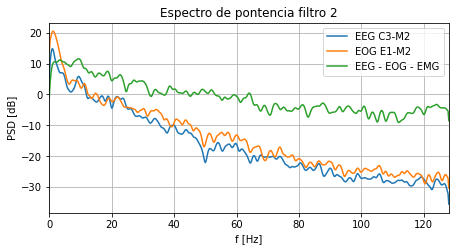

In [566]:
spectrum_plot_1([EEG, EOG, res2_RLS], N0, title='Espectro de pontencia filtro 2', fig_size=(7.16,3.5))

In [549]:
print('Power at 50 Hz =', get_power_at_f(res1_RLS, 50, N0))
print('Power at 1.25 Hz =', get_power_at_f(res1_RLS, 1.25, N0))
print('Power at 1.25 Hz =', get_power_at_f(res2_RLS, 1.25, N0))

Power at 50 Hz = [0.39805873]
Power at 1.25 Hz = [17.76080409]
Power at 1.25 Hz = [10.44258017]


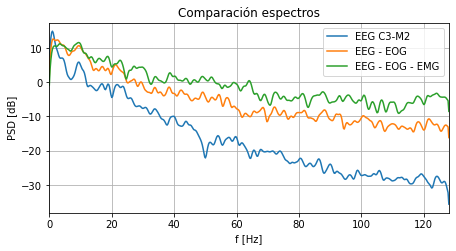

In [564]:
spectrum_plot_1([EEG, res1_RLS, res2_RLS], N0, title='Comparación espectros', fig_size=(7.16,3.5))

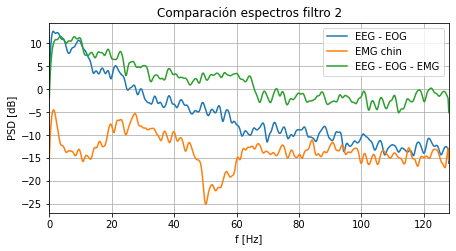

In [538]:
spectrum_plot_1([res1_RLS, EMG, res2_RLS], N0, title='Comparación espectros filtro 2', fig_size=(7.16,3.5))

In [483]:
def apply_rls(x_data, y_data, order_M, forget_factor, delta):

    N=x_data.shape[0]
    print(x_data.shape[0])
    
    
    inv_forget_factor=1/forget_factor
    
    #Arreglos a usar
    data_vector = np.zeros((order_M, 1)) 
    w = np.zeros((order_M, 1))
    g = np.zeros((order_M, 1))
    g_bar = np.zeros((order_M, 1))
    e_n = np.zeros(N)
    y_hat = np.zeros(N)
    
    if delta==0:
        P = np.eye(order_M)
    else:
        P = np.eye(order_M) / delta

    for i in range(N):
        data_vector = np.roll(data_vector, 1)
        data_vector[0] = x_data[i]
        
        g_bar[:,:] = inv_forget_factor * np.dot(P, data_vector)
        alpha_n=1 + np.dot(g_bar.T, data_vector)
        g[:,:] = g_bar / alpha_n
        P[:,:] = inv_forget_factor * P - np.dot(g, g_bar.T)
        P = (P + P.T) / 2
        
        #Filtrado
        y_hat[i]=np.dot(w.T, data_vector)
        e=y_data[i]-y_hat[i]
        e_n[i]=e
        #Actualizo los pesos
        w += g * e
    
    return y_hat, e_n, w 
